# [Paris Saclay Center for Data Science](http://www.datascience-paris-saclay.fr)

## [RAMP](https://www.ramp.studio/problems/MNIST_simplified) MNIST handwritten digit classification

_Mehdi Cherti (CNRS), Balázs Kégl (CNRS)_
    
## Introduction



## Data



## The prediction task

The goal of this RAMP is to classify correctly handwritten digits. For each submission, you will have to provide an image classifier (versus the original setup that required a transformer and a batch classifier). The images are usually big so loading them into the memory at once may be impossible. The image classifier therefore will access them through an `img_loader` function which can load one image at a time. 

## Hints

Setting up an AWS instance is easy, just follow [this tutorial](https://medium.com/@mateuszsieniawski/keras-with-gpu-on-amazon-ec2-a-step-by-step-instruction-4f90364e49ac#.dariq7i2u).

For learning the nuts and bolts of convolutional nets, we suggest that you follow [Andrej Karpathy’s excellent course](http://cs231n.github.io).

In [1]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import cm

%matplotlib inline

pd.set_option('display.max_rows', 500)

# The data

If the images are not yet in `data/imgs`, change the type of the net cell to "Code" and run it.

In [2]:
df = pd.read_csv('data/train.csv')
X_df = df['id']
y_df = df['class']
X = X_df.values
y = y_df.values

The class distribution is balanced.

In [3]:
labels_counts_df = df.groupby('class').count()
labels_counts_df

,id
class,
0,4742
1,5370
2,4795
3,4914
4,4675
5,4337
6,4709
7,4998
8,4707


It is worthwhile to look at some image panels, grouped by label. 

/Users/kegl/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


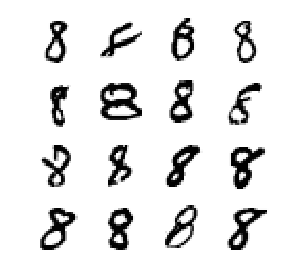

In [4]:
nb_rows = 4
nb_cols = 4
nb_elements = nb_rows * nb_cols
label = 8

df_given_label = df[df['class']==label]

subsample = np.random.choice(df_given_label['id'], replace=False, size=nb_elements)

fig = plt.figure(figsize=(4, 4))
grid = AxesGrid(fig, 111, # similar to subplot(141)
                nrows_ncols = (nb_rows, nb_cols),
                axes_pad = 0.05,
                label_mode = "1",
)
for i, image_id in enumerate(subsample):
    filename = 'data/imgs/{}'.format(image_id)
    image = imread(filename)
    im = grid[i].imshow(image, cmap='Greys', interpolation='nearest')
    grid[i].axis('off')
plt.tight_layout()

All images have size 28 $\times$ 28.

In [5]:
image.shape

(28, 28)

In [6]:
n_subsample = 1000
shapes = np.empty((n_subsample, 2))
for i, image_id in enumerate(X_df[:n_subsample]):
    filename = 'data/imgs/{}'.format(image_id)
    image = imread(filename)
    shapes[i] = image.shape

In [7]:
shapes_df = pd.DataFrame(shapes, columns=['height', 'width'])
shapes_df['count'] = 0
shapes_df.groupby(['height', 'width']).count().sort_values('count', ascending=False)

,,count
height,width,
28.0,28.0,1000


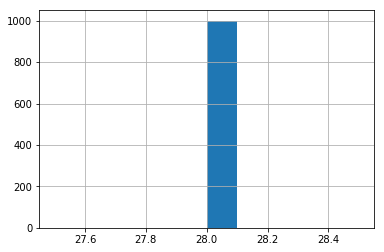

In [8]:
shapes_df['height'].hist()

# Image preprocessing

In the first workflow element image_preprocessor.py you can resize, crop, or rotate the images. This is an important step. Neural nets need standard-size images defined by the dimension of the input layer. MNIST images are centered and resized, so these operations are unlikely to be useful but rotation may help.

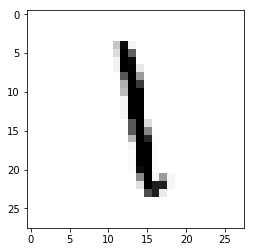

In [9]:
filename = 'data/imgs/{}'.format(X_df[161])
image = imread(filename)
plt.imshow(image, cmap='Greys', interpolation='nearest')
plt.show()

Here we resize the images to different resolutions, then blow them up so the difference can be visible.

/Users/kegl/anaconda/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


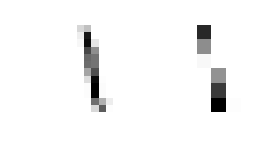

In [10]:
from skimage.transform import resize

nb_rows = 1
nb_cols = 2
nb_elements = nb_rows * nb_cols


fig = plt.figure(figsize=(4, 4))
grid = AxesGrid(fig, 111, # similar to subplot(141)
                nrows_ncols = (nb_rows, nb_cols),
                axes_pad = 0.05,
                label_mode = "1",
)
grid[0].imshow(
    resize(resize(image, (16, 16)), (224, 224), order=0),
    cmap='Greys', interpolation='nearest')
grid[0].axis('off')
grid[1].imshow(
    resize(resize(image, (8, 8)), (224, 224), order=0),
    cmap='Greys', interpolation='nearest')
grid[1].axis('off')
plt.tight_layout()

Here we rotate the image. Explore options in skimage.

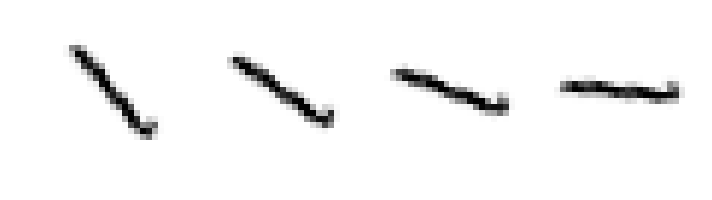

In [11]:
from skimage.transform import rotate

nb_rows = 1
nb_cols = 4
nb_elements = nb_rows * nb_cols

fig = plt.figure(figsize=(10, 10))
grid = AxesGrid(fig, 111, # similar to subplot(141)
                nrows_ncols = (nb_rows, nb_cols),
                axes_pad = 0.05,
                label_mode = "1",
)
grid[0].imshow(rotate(image, 30), cmap='Greys', interpolation='nearest')
grid[0].axis('off')
grid[1].imshow(rotate(image, 45), cmap='Greys', interpolation='nearest')
grid[1].axis('off')
grid[2].imshow(rotate(image, 60), cmap='Greys', interpolation='nearest')
grid[2].axis('off')
grid[3].imshow(rotate(image, 75), cmap='Greys', interpolation='nearest')
grid[3].axis('off')
plt.tight_layout()

All these tansformations should be implemented in the transform function found in the `image_preprocessor` workflow element that you will submit.

## The pipeline

For submitting at the [RAMP site](http://ramp.studio), you will have to write a single ImageClassifier class implementing a `fit` and a `predict_proba` function.

Note that the following code cells are *not* executed in the notebook. The notebook saves their contents in the file specified in the first line of the cell, so you can edit your submission before running the local test below and submitting it at the RAMP site.

### The starting kit image classifier

The starting kit implements a simple keras neural net. Since MNIST is a small set of small images, we can actually load them into the memory. MNIST contains well-centered and aligned images so `_transform` only needs to scale the pixels into `[0, 1]`. 

In [31]:
%%file submissions/starting_kit/image_classifier.py
import numpy as np

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD


class ImageClassifier(object):

    def __init__(self):
        inp = Input((28, 28, 1))
        x = Flatten(name='flatten')(inp)
        x = Dense(100, activation='relu', name='fc1')(x)
        out = Dense(10, activation='softmax', name='predictions')(x)
        self.model = Model(inp, out)
        self.model.compile(
            loss='categorical_crossentropy',
            optimizer=SGD(lr=1e-4),
            metrics=['accuracy'])

    def _transform(self, x):
        # adding channel dimension at the last position
        x = np.expand_dims(x, axis=-1)
        # bringing input between 0 and 1
        x = x / 255.
        return x

    def fit(self, img_loader):
        # load the full data into memory
        nb = len(img_loader)
        # make a 4D tensor:
        # number of images x width x height x number of channels
        X = np.zeros((nb, 28, 28, 1))
        # one-hot encoding of the labels to set NN target
        Y = np.zeros((nb, 10))
        for i in range(nb):
            x, y = img_loader.load(i)
            X[i] = self._transform(x)
            # since labels are [0, ..., 9], label is the same as label index
            Y[i, y] = 1
        self.model.fit(X, Y, batch_size=32, validation_split=0.1, epochs=1)

    def predict_proba(self, img_loader):
        nb = len(img_loader)
        X = np.zeros((nb, 28, 28, 1))
        for i in range(nb):
            X[i] = self._transform(img_loader.load(i))
        return self.model.predict(X)



Overwriting submissions/starting_kit/image_classifier.py


### A simple keras convnet

In [32]:
%%file submissions/keras_convnet/image_classifier.py
import numpy as np

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.optimizers import Adam

class ImageClassifier(object):

    def __init__(self):
        inp = Input((28, 28, 1))
        # Block 1
        x = Conv2D(
            32, (3, 3), activation='relu', padding='same',
            name='block1_conv1')(inp)
        x = Conv2D(
            32, (3, 3), activation='relu', padding='same',
            name='block1_conv2')(x)
        x = MaxPooling2D(
            (2, 2), strides=(2, 2),
            name='block1_pool')(x)
        # dense
        x = Flatten(
            name='flatten')(x)
        x = Dense(
            512, activation='relu',
            name='fc1')(x)
        out = Dense(10, activation='softmax', name='predictions')(x)
        self.model = Model(inp, out)
        self.model.compile(
            loss='categorical_crossentropy',
            optimizer=Adam(lr=1e-4),
            metrics=['accuracy'])

    def _transform(self, x):
        # adding channel dimension at the last position
        x = np.expand_dims(x, axis=-1)
        # bringing input between 0 and 1
        x = x / 255.
        return x

    def fit(self, img_loader):
        # load the full data into memory
        nb = len(img_loader)
        # make a 4D tensor:
        # number of images x width x height x number of channels
        X = np.zeros((nb, 28, 28, 1))
        # one-hot encoding of the labels to set NN target
        Y = np.zeros((nb, 10))
        for i in range(nb):
            x, y = img_loader.load(i)
            X[i] = self._transform(x)
            # since labels are [0, ..., 9], label is the same as label index
            Y[i, y] = 1
        self.model.fit(X, Y, batch_size=32, validation_split=0.1, epochs=1)

    def predict_proba(self, img_loader):
        nb = len(img_loader)
        X = np.zeros((nb, 28, 28, 1))
        for i in range(nb):
            X[i] = self._transform(img_loader.load(i))
        return self.model.predict(X)



Overwriting submissions/keras_convnet/image_classifier.py


### A simple pytorch convnet

In [3]:
%%file submissions/pytorch_convnet/image_classifier.py
from __future__ import division
import time
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

is_cuda = torch.cuda.is_available()


def _make_variable(X):
    variable = Variable(torch.from_numpy(X))
    if is_cuda:
        variable = variable.cuda()
    return variable


def _flatten(x):
    return x.view(x.size(0), -1)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 14 * 14, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.block1(x)
        x = _flatten(x)
        x = self.fc(x)
        return x

    def _initialize_weights(self):
        # Source: https://github.com/pytorch/vision/blob/master/torchvision/
        # models/vgg.py
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


class ImageClassifier(object):

    def __init__(self):
        self.net = Net()
        if is_cuda:
            self.net = self.net.cuda()

    def _transform(self, x):
        # adding channel dimension at the first position
        x = np.expand_dims(x, axis=0)
        # bringing input between 0 and 1
        x = x / 255.
        return x

    def _get_acc(self, y_pred, y_true):
        y_pred = y_pred.cpu().data.numpy().argmax(axis=1)
        y_true = y_true.cpu().data.numpy()
        return (y_pred == y_true)

    def _load_minibatch(self, img_loader, indexes):
        n_minibatch_images = len(indexes)
        X = np.zeros((n_minibatch_images, 1, 28, 28), dtype=np.float32)
        # one-hot encoding of the labels to set NN target
        y = np.zeros(n_minibatch_images, dtype=np.int)
        for i, i_load in enumerate(indexes):
            x, y[i] = img_loader.load(i_load)
            X[i] = self._transform(x)
            # since labels are [0, ..., 9], label is the same as label index
        X = _make_variable(X)
        y = _make_variable(y)
        return X, y

    def _load_test_minibatch(self, img_loader, indexes):
        n_minibatch_images = len(indexes)
        X = np.zeros((n_minibatch_images, 1, 28, 28), dtype=np.float32)
        for i, i_load in enumerate(indexes):
            x = img_loader.load(i_load)
            X[i] = self._transform(x)
        X = _make_variable(X)
        return X

    def fit(self, img_loader):
        validation_split = 0.1
        batch_size = 32
        nb_epochs = 1
        lr = 1e-4
        optimizer = optim.Adam(self.net.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss().cuda()
        if is_cuda:
            criterion = criterion.cuda()

        for epoch in range(nb_epochs):
            t0 = time.time()
            self.net.train()  # train mode
            nb_trained = 0
            nb_updates = 0
            train_loss = []
            train_acc = []
            n_images = len(img_loader) * (1 - validation_split)
            i = 0
            while i < n_images:
                indexes = range(i, min(i + batch_size, n_images))
                X, y = self._load_minibatch(img_loader, indexes)
                i += len(indexes)
                # zero-out the gradients because they accumulate by default
                optimizer.zero_grad()
                y_pred = self.net(X)
                loss = criterion(y_pred, y)
                loss.backward()  # compute gradients
                optimizer.step()  # update params

                # Loss and accuracy
                train_acc.extend(self._get_acc(y_pred, y))
                train_loss.append(loss.data[0])
                nb_trained += X.size(0)
                nb_updates += 1
                if nb_updates % 100 == 0:
                    print(
                        'Epoch [{}/{}], [trained {}/{}], avg_loss: {:.4f}'
                        ', avg_train_acc: {:.4f}'.format(
                            epoch + 1, nb_epochs, nb_trained, n_images,
                            np.mean(train_loss), np.mean(train_acc)))

            self.net.eval()  # eval mode
            valid_acc = []
            n_images = len(img_loader)
            while i < n_images:
                indexes = range(i, min(i + batch_size, n_images))
                X, y = self._load_minibatch(img_loader, indexes)
                i += len(indexes)
                y_pred = self.net(X)
                valid_acc.extend(self._get_acc(y_pred, y))

            delta_t = time.time() - t0
            print('Finished epoch {}'.format(epoch + 1))
            print('Time spent : {:.4f}'.format(delta_t))
            print('Train acc : {:.4f}'.format(np.mean(train_acc)))
            print('Valid acc : {:.4f}'.format(np.mean(valid_acc)))

    def predict_proba(self, img_loader):
        batch_size = 32
        n_images = len(img_loader)
        i = 0
        y_proba = np.empty((n_images, 10))
        while i < n_images:
            indexes = range(i, min(i + batch_size, n_images))
            X = self._load_test_minibatch(img_loader, indexes)
            i += len(indexes)
            y_proba[indexes] = nn.Softmax()(self.net(X)).cpu().data.numpy()
        return y_proba



Overwriting submissions/pytorch_convnet/image_classifier.py


## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](/tree/submissions/starting_kit), not on the classes defined in the cells of this notebook.

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python file `image_classifier.py` is in the  [`submissions/starting_kit`](/tree/submissions/starting_kit) folder, and the data `train.csv` and `test.csv` are in [`data`](/tree/data). If you haven't yet, download the images by executing `python download_data.py`. Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

In [1]:
!ramp_test_submission

Testing MNIST classification
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
Using TensorFlow backend.
Train on 34560 samples, validate on 3840 samples
Epoch 1/1
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
W tenso

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good feature extractor and classifier, you can submit them to [ramp.studio](http://www.ramp.studio). First, if it is your first time using RAMP, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then find an open event on the particular problem, for example, the event [MNIST](http://www.ramp.studio/events/MNIST_simplified) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/MNIST_simplified/sandbox) and copy-paste (or upload) [`image_preprocessor.py`](/edit/submissions/starting_kit/image_preprocessor.py) and [`batch_classifier.py`](/edit/submissions/starting_kit/batch_classifier.py) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/MNIST_simplified/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://www.ramp.studio/events/MNIST_simplified/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/MNIST_simplified/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints mean cross-validation scores 
```
----------------------------
train acc = 0.132 ± 0.0
train nll = 2.294 ± 0.0
valid acc = 0.132 ± 0.0
valid nll = 2.294 ± 0.0
test acc = 0.129 ± 0.0
test nll = 2.293 ± 0.0
```
The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://www.ramp.studio/events/MNIST_simplified/leaderboard)) is balanced accuracy aka macro-averaged recall, so the line that is relevant in the output of `ramp_test_submission` is `valid acc = 0.132 ± 0.0`. When the score is good enough, you can submit it at the RAMP.

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=MNIST simplified notebook).